In [1]:
import pandas as pd, numpy as np
# import matplotlib.pyplot as plt
import lsff_output_processing as lop
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

!whoami
!date

nicoly
Tue Mar 31 12:21:38 PDT 2020


In [2]:
%load_ext autoreload
%autoreload 2

# Compute birth prevalence of NTDs in baseline and intervention scenarios, and the difference between the two


## 1. Load all count space data tables and see what they are

In [3]:
base_directory = '/share/costeffectiveness/results/vivarium_conic_lsff/v4.0_folic_acid_fortification'

locations_rundates = {
    'Ethiopia': '2020_03_18_23_04_26',
    'India': '2020_03_18_23_04_36',
    'Nigeria': '2020_03_18_23_04_42',
}

In [4]:
data = lop.load_all_transformed_count_data(base_directory, locations_rundates)

In [5]:
[k for k in data.keys() if k[0] == 'ethiopia' or 'india' or 'nigeria']

[('ethiopia', 'gestational_age'),
 ('ethiopia', 'transition_count'),
 ('ethiopia', 'deaths'),
 ('ethiopia', 'state_person_time'),
 ('ethiopia', 'births_with_ntd'),
 ('ethiopia', 'population'),
 ('ethiopia', 'person_time'),
 ('ethiopia', 'ylls'),
 ('ethiopia', 'ylds'),
 ('ethiopia', 'births'),
 ('ethiopia', 'birth_weight'),
 ('india', 'gestational_age'),
 ('india', 'transition_count'),
 ('india', 'deaths'),
 ('india', 'state_person_time'),
 ('india', 'births_with_ntd'),
 ('india', 'population'),
 ('india', 'person_time'),
 ('india', 'ylls'),
 ('india', 'ylds'),
 ('india', 'births'),
 ('india', 'birth_weight'),
 ('nigeria', 'gestational_age'),
 ('nigeria', 'transition_count'),
 ('nigeria', 'deaths'),
 ('nigeria', 'state_person_time'),
 ('nigeria', 'births_with_ntd'),
 ('nigeria', 'population'),
 ('nigeria', 'person_time'),
 ('nigeria', 'ylls'),
 ('nigeria', 'ylds'),
 ('nigeria', 'births'),
 ('nigeria', 'birth_weight')]

## 2. EXPLORE: Get data to compute NTD birth prevalence in Ethiopia

### First load NTD births and do a quick data check

In [6]:
data[('ethiopia', 'births_with_ntd')].head()

#1500 rows × 7 columns: 5 years*2 sexes * 25 input draws * 2 scenarios 

,year,sex,fortification_group,measure,input_draw,scenario,value
0,2020,female,false,live_births_with_ntds,21,baseline,42.0
1,2020,female,false,live_births_with_ntds,21,folic_acid_fortification_scale_up,40.0
2,2020,female,false,live_births_with_ntds,29,baseline,38.0
3,2020,female,false,live_births_with_ntds,29,folic_acid_fortification_scale_up,38.0
4,2020,female,false,live_births_with_ntds,55,baseline,27.0


In [7]:
data[('ethiopia', 'births_with_ntd')].groupby(['fortification_group']).value.describe()

#we dont care about the unknown(we only care about those born into the sim cuz of birth prevalence)

,count,mean,std,min,25%,50%,75%,max
fortification_group,,,,,,,,
false,500.0,66.518,21.860408,15.0,50.0,69.0,82.0,121.0
true,500.0,3.586,6.107471,0.0,0.0,0.0,5.0,37.0
unknown,500.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0


In [8]:
data[('ethiopia', 'births_with_ntd')].groupby(['scenario']).value.describe()

,count,mean,std,min,25%,50%,75%,max
scenario,,,,,,,,
baseline,750.0,24.166667,36.209673,0.0,0.0,0.0,58.0,121.0
folic_acid_fortification_scale_up,750.0,22.569333,29.991763,0.0,0.0,5.0,46.0,107.0


### Now load all live births and do a quick data check

In [9]:
data[('ethiopia', 'births')].head()

,year,sex,fortification_group,measure,input_draw,scenario,value
0,2020,female,false,live_births,21,baseline,21508.0
1,2020,female,false,live_births,21,folic_acid_fortification_scale_up,20577.0
2,2020,female,false,live_births,29,baseline,21827.0
3,2020,female,false,live_births,29,folic_acid_fortification_scale_up,20978.0
4,2020,female,false,live_births,55,baseline,21611.0


In [10]:
data[('ethiopia', 'births')].groupby(['scenario']).value.describe()

,count,mean,std,min,25%,50%,75%,max
scenario,,,,,,,,
baseline,750.0,13401.716,19519.837500,0.0,0.0,1.0,42783.5,46484.0
folic_acid_fortification_scale_up,750.0,13401.716,16103.652463,0.0,0.0,4788.0,29566.5,46042.0


### See how many draws there are (25)

In [11]:
data[('ethiopia', 'births')].input_draw.unique()

array([ 21,  29,  55,  78, 155, 223, 232, 254, 307, 357, 394, 417, 482,
       514, 524, 533, 602, 620, 629, 650, 674, 680, 733, 829, 946])

In [12]:
data[('ethiopia', 'births')].input_draw.nunique()

25

### Note:

-that there will be zero births in strata 'unknown fortification status' since `'unknown'` only gets assigned to simulants alive (older than 0) at the beginning.

-sometimes there are also zero births in strata 'fortification status  = `'true''. This makes sense because baseline coverage of fortification is very low: there are fewer people who are fortified than unfortified.

-there shouldn't be any draws with zero births overall

In [13]:
data[('ethiopia', 'births')].query('value == 0').head()

,year,sex,fortification_group,measure,input_draw,scenario,value
50,2020,female,true,live_births,21,baseline,0.0
52,2020,female,true,live_births,29,baseline,0.0
60,2020,female,true,live_births,223,baseline,0.0
64,2020,female,true,live_births,254,baseline,0.0
66,2020,female,true,live_births,307,baseline,0.0


In [14]:
data[('ethiopia', 'births')].query('value == 0').shape

(612, 7)

In [15]:
data[('ethiopia', 'births')].query('value == 0').fortification_group.unique()

array(['true', 'unknown'], dtype=object)

## 3. Recompute NTD prevalence, aggregating over fortification group and sex first

In [16]:
data[('ethiopia', 'births_with_ntd')].head()

,year,sex,fortification_group,measure,input_draw,scenario,value
0,2020,female,false,live_births_with_ntds,21,baseline,42.0
1,2020,female,false,live_births_with_ntds,21,folic_acid_fortification_scale_up,40.0
2,2020,female,false,live_births_with_ntds,29,baseline,38.0
3,2020,female,false,live_births_with_ntds,29,folic_acid_fortification_scale_up,38.0
4,2020,female,false,live_births_with_ntds,55,baseline,27.0


In [17]:
# Test agggregation
# Aggregate over sex and fortification group, and index by the following columns:
groupby_cols = ['year', 'scenario', 'input_draw']
data[('ethiopia', 'births_with_ntd')].groupby(groupby_cols).value.sum().head(30) #sumntd_births over sex/fort_group

year  scenario                           input_draw
2020  baseline                           21             81.0
                                         29             75.0
                                         55             72.0
                                         78             89.0
                                         155            86.0
                                         223            87.0
                                         232            77.0
                                         254            49.0
                                         307            79.0
                                         357           100.0
                                         394            78.0
                                         417            72.0
                                         482            88.0
                                         514            86.0
                                         524            82.0
                                 

## 4. All countries

In [172]:
locations = ['ethiopia','india','nigeria']

In [173]:
ntd_births=pd.DataFrame()
for i in locations:
# Load data for NTD births and live births
    df = data[i,'births_with_ntd']
    df['locations']=i
    ntd_births = ntd_births.append(df).dropna()
ntd_births.head()

#4500 rows

,year,sex,fortification_group,measure,input_draw,scenario,value,locations
0,2020,female,false,live_births_with_ntds,21,baseline,42.0,ethiopia
1,2020,female,false,live_births_with_ntds,21,folic_acid_fortification_scale_up,40.0,ethiopia
2,2020,female,false,live_births_with_ntds,29,baseline,38.0,ethiopia
3,2020,female,false,live_births_with_ntds,29,folic_acid_fortification_scale_up,38.0,ethiopia
4,2020,female,false,live_births_with_ntds,55,baseline,27.0,ethiopia


In [174]:
#NTD BIRTH PREVALENCE CALCUCATION

# Define index columns - those we will NOT aggregate over
groupby_cols_5yr = ['locations','year','scenario','input_draw']
groupby_cols_allyr = ['locations','scenario','input_draw'] #collapse over years

ntd_births=pd.DataFrame()
live_births=pd.DataFrame()

for i in locations:
# Load data for NTD births and live births
    df1 = data[i,'births_with_ntd']
    df1['locations']=i
    ntd_births = ntd_births.append(df1).dropna()
    
    df2 = data[i,'births']
    df2['locations']=i
    live_births=live_births.append(df2).dropna()

# Aggregate (sum) over sex and fortification_group
ntd_births_allyr = ntd_births.groupby(groupby_cols_allyr).value.sum()
ntd_births_5yr = ntd_births.groupby(groupby_cols_5yr).value.sum()

live_births_allyr = live_births.groupby(groupby_cols_allyr).value.sum()
live_births_5yr = live_births.groupby(groupby_cols_5yr).value.sum()

# Divide the two pandas Series to get birth prevalence
# Multiply by 1000 to get ntd births per 1000 live births
ntd_birth_prevalence_allyr =  1000 * ntd_births_allyr / live_births_allyr
ntd_birth_prevalence_5yr =  1000 * ntd_births_5yr / live_births_5yr

# Reset the index to get a dataframe
ntd_birth_prevalence_allyr = ntd_birth_prevalence_allyr.reset_index()
ntd_birth_prevalence_5yr = ntd_birth_prevalence_5yr.reset_index()


# See what we got
ntd_birth_prevalence_5yr.head()


,locations,year,scenario,input_draw,value
0,ethiopia,2020,baseline,21,1.823626
1,ethiopia,2020,baseline,29,1.673509
2,ethiopia,2020,baseline,55,1.612361
3,ethiopia,2020,baseline,78,1.983685
4,ethiopia,2020,baseline,155,1.901645


### Check shape and check that we have no NaN's this time

In [111]:
ntd_birth_prevalence_5yr.shape
##location3 x scenarios2 X draws25 

(750, 5)

In [112]:
ntd_birth_prevalence_allyr.shape

(150, 4)

In [114]:
# Check whether any values are NaN (By definition, value is NaN iff value != value)
# No NaN's this time -- good
ntd_birth_prevalence_5yr.query('value != value') 

#if there is an NaN, by definition it is not equal to itself

,locations,year,scenario,input_draw,value


### Get separate baseline and intervention dataframes

In [158]:
baseline_ntd_birth_prevalence_5yr = ntd_birth_prevalence_5yr.query('scenario == "baseline"')
baseline_ntd_birth_prevalence_allyr = ntd_birth_prevalence_allyr.query('scenario == "baseline"')

intervention_ntd_birth_prevalence_5yr = ntd_birth_prevalence_5yr.query('scenario == "folic_acid_fortification_scale_up"')
intervention_ntd_birth_prevalence_allyr = ntd_birth_prevalence_allyr.query('scenario == "folic_acid_fortification_scale_up"')

intervention_ntd_birth_prevalence_allyr.head()

,locations,scenario,input_draw,value
25,ethiopia,folic_acid_fortification_scale_up,21,1.737691
26,ethiopia,folic_acid_fortification_scale_up,29,1.635357
27,ethiopia,folic_acid_fortification_scale_up,55,1.566262
28,ethiopia,folic_acid_fortification_scale_up,78,1.665992
29,ethiopia,folic_acid_fortification_scale_up,155,1.824214


### Get stats across draws for baseline and intervention

In [159]:
baseline_5yr=baseline_ntd_birth_prevalence_5yr.groupby(['locations','year']).value.describe()
baseline_5yr=baseline_5yr.reset_index()
baseline_5yr.head()

,locations,year,count,mean,std,min,25%,50%,75%,max
0,ethiopia,2020,25.0,1.771674,0.240507,1.092311,1.617868,1.770308,1.920715,2.234237
1,ethiopia,2021,25.0,1.808447,0.185874,1.415476,1.692275,1.799400,1.913330,2.153081
2,ethiopia,2022,25.0,1.813058,0.193964,1.483713,1.673304,1.857280,1.929657,2.185241
3,ethiopia,2023,25.0,1.838943,0.208964,1.361003,1.713825,1.827088,1.945330,2.190962
4,ethiopia,2024,25.0,1.768331,0.208949,1.356274,1.612632,1.758197,1.817837,2.290938


In [160]:
baseline_allyr=baseline_ntd_birth_prevalence_allyr.groupby(['locations']).value.describe()
baseline_allyr=baseline_allyr.reset_index()
baseline_allyr.head()

,locations,count,mean,std,min,25%,50%,75%,max
0,ethiopia,25.0,1.803205,0.141016,1.543422,1.699041,1.795814,1.878913,2.126173
1,india,25.0,0.721130,0.079411,0.591765,0.666996,0.703183,0.770648,0.890707
2,nigeria,25.0,2.561869,0.206511,2.269127,2.401464,2.532484,2.635766,3.061953


In [161]:
intervention_5yr=intervention_ntd_birth_prevalence_5yr.groupby(['locations','year']).value.describe()
intervention_5yr=intervention_5yr.reset_index()
intervention_5yr.head()

,locations,year,count,mean,std,min,25%,50%,75%,max
0,ethiopia,2020,25.0,1.659874,0.235887,1.092311,1.500392,1.673509,1.853713,2.122526
1,ethiopia,2021,25.0,1.696948,0.177045,1.246967,1.573661,1.674398,1.802145,2.063834
2,ethiopia,2022,25.0,1.695644,0.172731,1.350773,1.578497,1.727871,1.843484,1.975353
3,ethiopia,2023,25.0,1.706696,0.250388,1.124796,1.607428,1.715016,1.855889,2.146019
4,ethiopia,2024,25.0,1.648974,0.241684,1.060895,1.525392,1.661704,1.762738,2.168010


### Compute difference between baseline and intervention

In [162]:
baseline_ntd_birth_prevalence_5yr.head()

,locations,year,scenario,input_draw,value
0,ethiopia,2020,baseline,21,1.823626
1,ethiopia,2020,baseline,29,1.673509
2,ethiopia,2020,baseline,55,1.612361
3,ethiopia,2020,baseline,78,1.983685
4,ethiopia,2020,baseline,155,1.901645


In [175]:
index_columns_5yr = ['locations','year','input_draw']
index_columns_allyr = ['locations','input_draw']

baseline5yr = baseline_ntd_birth_prevalence_5yr.set_index(index_columns_5yr).value
intervention5yr = intervention_ntd_birth_prevalence_5yr.set_index(index_columns_5yr).value
delta_ntd_birth_prevalence_5yr = (baseline5yr - intervention5yr).reset_index()

baselineallyr = baseline_ntd_birth_prevalence_allyr.set_index(index_columns_allyr).value
interventionallyr = intervention_ntd_birth_prevalence_allyr.set_index(index_columns_allyr).value
delta_ntd_birth_prevalence_allyr = (baselineallyr - interventionallyr).reset_index()

### Get stats by year for the difference

### That's weird -- there's a decrease in 2020, but that year should be the same as baseline

With common random numbers, shouldn't the intervention scenario in 2020 be exactly the same as the baseline scenario, so the difference should be identically zero at the draw level? 

### But at least now the intervention has a positive effect -- that's a relief

### Change in birth prevalence:

In [176]:
delta_5yr=delta_ntd_birth_prevalence_5yr.groupby(['locations','year']).value.describe()
delta_5yr=delta_5yr.reset_index()
delta_5yr.head()

,locations,year,count,mean,std,min,25%,50%,75%,max
0,ethiopia,2020,25.0,0.111799,0.126056,0.000000,0.022514,0.067092,0.155424,0.583117
1,ethiopia,2021,25.0,0.111498,0.117017,0.000000,0.033580,0.078783,0.156778,0.491082
2,ethiopia,2022,25.0,0.117413,0.134730,0.000000,0.033349,0.067432,0.123408,0.581747
3,ethiopia,2023,25.0,0.132248,0.133108,0.011249,0.033627,0.089440,0.179043,0.593691
4,ethiopia,2024,25.0,0.119356,0.128751,0.000000,0.033265,0.066805,0.156956,0.569533


In [177]:
delta_allyr=delta_ntd_birth_prevalence_allyr.groupby(['locations']).value.describe()
delta_allyr=delta_allyr.reset_index()
delta_allyr.head()

,locations,count,mean,std,min,25%,50%,75%,max
0,ethiopia,25.0,0.119187,0.124006,0.002486,0.034901,0.077117,0.151454,0.561643
1,india,25.0,0.016144,0.007552,0.005838,0.008799,0.014622,0.023353,0.029195
2,nigeria,25.0,0.182189,0.046370,0.090728,0.151874,0.178729,0.211346,0.284172


In [178]:
baseline_allyr.head()

,locations,count,mean,std,min,25%,50%,75%,max
0,ethiopia,25.0,1.803205,0.141016,1.543422,1.699041,1.795814,1.878913,2.126173
1,india,25.0,0.721130,0.079411,0.591765,0.666996,0.703183,0.770648,0.890707
2,nigeria,25.0,2.561869,0.206511,2.269127,2.401464,2.532484,2.635766,3.061953


## 5. PLOTTING!!!!

Text(0.5, 1.0, 'Difference in neural tube defects (NTD) per 1000 live births between intervention and baseline scenario')

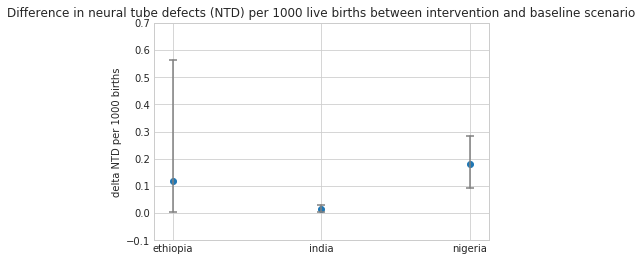

In [104]:
#collapsed over years, NTD difference in prevalence

plt.ylim([-.1,.7])
plt.scatter(delta['locations'],delta['mean'])
plt.scatter(delta['locations'],delta['min'], marker='_', c='grey', s=50)
plt.scatter(delta['locations'],delta['max'], marker='_', c='grey', s=50)
# plt.plot([(0-0.1),(1),(2+0.1)], [0,0,0],'--',c='grey')
plt.plot(([0,1,2],[0,1,2]),(delta['min'], delta['max']),c='grey')
plt.ylabel('delta NTD per 1000 births')

plt.title('Difference in neural tube defects (NTD) per 1000 live births between intervention and baseline scenario')




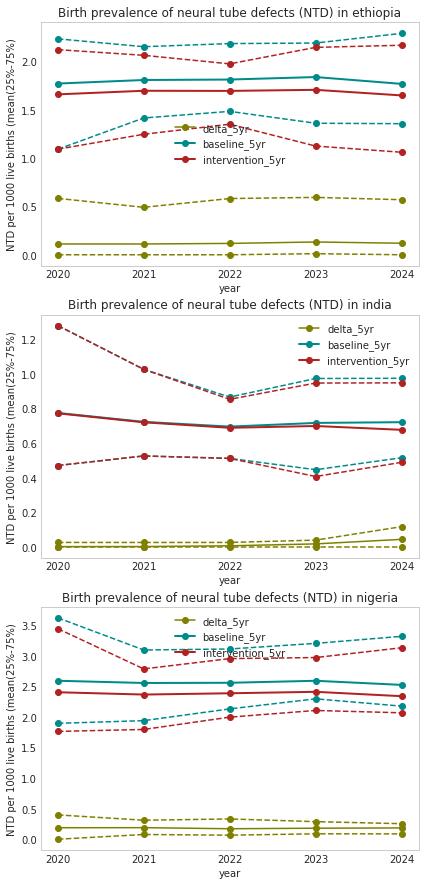

In [170]:
#5 yeqar plots
from pylab import *

num=1

for i in locations:
    
    subplot(3,1,num)
    plt.plot('year', 'mean', data=delta_5yr[delta_5yr['locations'] == i], marker='o', color='olive', label='delta_5yr')
    plt.plot('year', 'min',  data=delta_5yr[delta_5yr['locations'] == i], marker='o', color='olive', linestyle='dashed', label='')
    plt.plot('year', 'max', data=delta_5yr[delta_5yr['locations'] == i], marker='o', color='olive', linestyle='dashed',label='')
    plt.title('Birth prevalence of neural tube defects (NTD) in %s' %i)
 
    plt.plot('year', 'mean', data=baseline_5yr[baseline_5yr['locations'] == i], marker='o', color='DarkCyan', linewidth=2, label='baseline_5yr')
    plt.plot('year', 'min',  data=baseline_5yr[baseline_5yr['locations'] == i], marker='o', color='DarkCyan', linestyle='dashed', label='')
    plt.plot('year', 'max', data=baseline_5yr[baseline_5yr['locations'] == i], marker='o', color='DarkCyan', linestyle='dashed', label='')
    plt.ylabel("NTD per 1000 live births (mean(25%-75%)")

    plt.plot('year', 'mean', data=intervention_5yr[intervention_5yr['locations'] == i], marker='o', color='FireBrick', linewidth=2, label='intervention_5yr')
    plt.plot('year', 'min',  data=intervention_5yr[intervention_5yr['locations'] == i], marker='o', color='FireBrick', linestyle='dashed', label='')
    plt.plot('year', 'max', data=intervention_5yr[intervention_5yr['locations'] == i], marker='o', color='FireBrick', linestyle='dashed', label='')
    plt.xlabel("year")
    plt.legend()
    plt.subplots_adjust(right=1, top=3)
    plt.grid(b=None)
    num=num+1

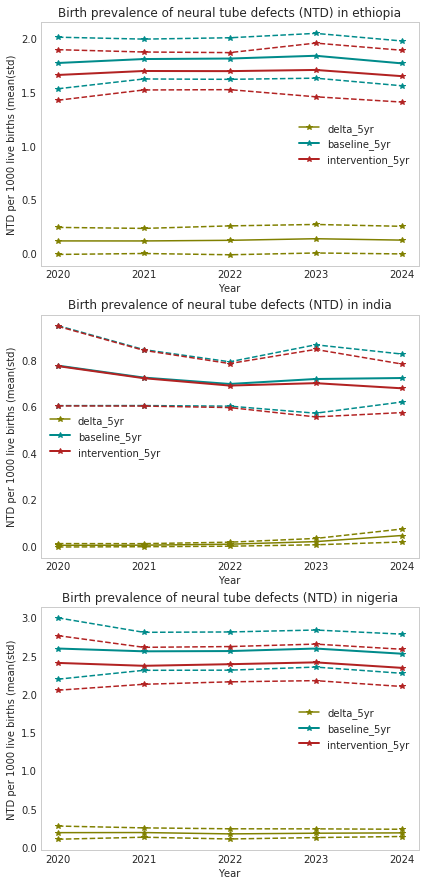

In [168]:
delta_5yr['mean-sd']=delta_5yr['mean']-delta_5yr['std']
delta_5yr['mean+sd']=delta_5yr['mean']+delta_5yr['std']

baseline_5yr['mean-sd']=baseline_5yr['mean']-baseline_5yr['std']
baseline_5yr['mean+sd']=baseline_5yr['mean']+baseline_5yr['std']

intervention_5yr['mean-sd']=intervention_5yr['mean']-intervention_5yr['std']
intervention_5yr['mean+sd']=intervention_5yr['mean']+intervention_5yr['std']

from pylab import *

num=1

for i in locations:
    
    subplot(3,1,num)
    plt.plot('year', 'mean', data=delta_5yr[delta_5yr['locations'] == i], marker='*', color='olive', label='delta_5yr')
    plt.plot('year', 'mean-sd',  data=delta_5yr[delta_5yr['locations'] == i], marker='*', color='olive', linestyle='dashed', label='')
    plt.plot('year', 'mean+sd', data=delta_5yr[delta_5yr['locations'] == i], marker='*', color='olive', linestyle='dashed',label='')
    plt.title('Birth prevalence of neural tube defects (NTD) in %s' %i)
 
    plt.plot('year', 'mean', data=baseline_5yr[baseline_5yr['locations'] == i], marker='*', color='DarkCyan', linewidth=2, label='baseline_5yr')
    plt.plot('year', 'mean-sd',  data=baseline_5yr[baseline_5yr['locations'] == i], marker='*', color='DarkCyan', linestyle='dashed', label='')
    plt.plot('year', 'mean+sd', data=baseline_5yr[baseline_5yr['locations'] == i], marker='*', color='DarkCyan', linestyle='dashed', label='')
    plt.ylabel("NTD per 1000 live births (mean(std)")

    plt.plot('year', 'mean', data=intervention_5yr[intervention_5yr['locations'] == i], marker='*', color='FireBrick', linewidth=2, label='intervention_5yr')
    plt.plot('year', 'mean-sd',  data=intervention_5yr[intervention_5yr['locations'] == i], marker='*', color='FireBrick', linestyle='dashed', label='')
    plt.plot('year', 'mean+sd', data=intervention_5yr[intervention_5yr['locations'] == i], marker='*', color='FireBrick', linestyle='dashed', label='')
    plt.xlabel("Year")
    plt.legend()
    plt.subplots_adjust(right=1, top=3)
    plt.grid(b=None)
    num=num+1


